This notebook shows the implementation of Linear Regression using SGD with and without Momentum

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df_data=pd.read_csv(r'/kaggle/input/housing-csv/housing.csv')

In [3]:
print (df_data.shape)
print (df_data.head())
print(df_data.dtypes)

(20640, 10)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
longitude             float64
latitude              float64
hou

In [4]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [5]:
df_data["total_bedrooms"].fillna((df_data["total_bedrooms"].mean()), inplace=True)

/tmp/ipykernel_18/3403723495.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_data["total_bedrooms"].fillna((df_data["total_bedrooms"].mean()), inplace=True)


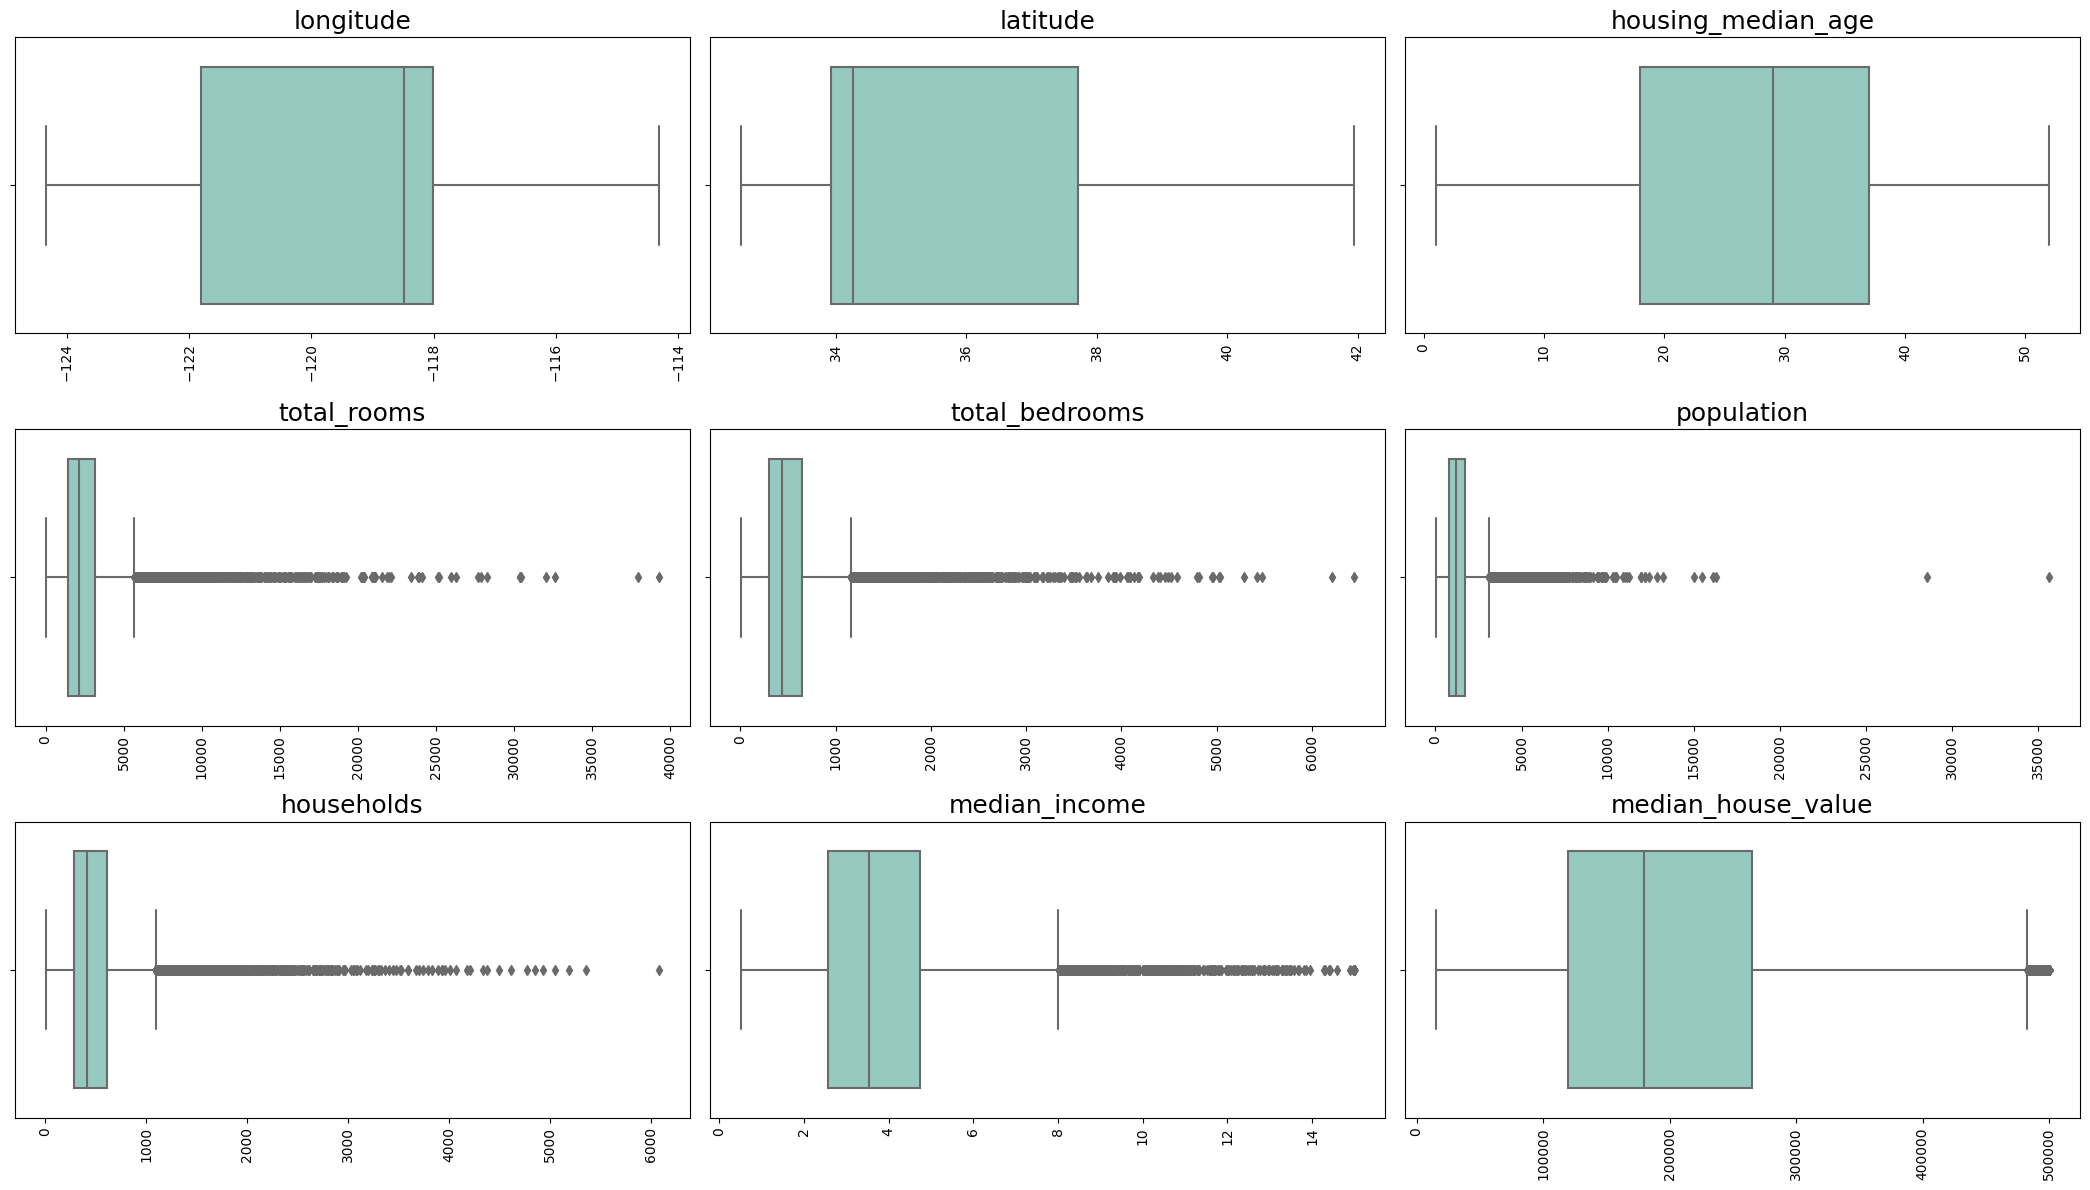

In [6]:
df_float=df_data.select_dtypes(include="float").columns

n_cols=3
n_rows=(len(df_float)-1)// n_cols + 1
fig,ax= plt.subplots(n_rows,n_cols,figsize=(21,4*n_rows))
ax=ax.flatten()
sns.set_style('darkgrid')
sns.set_palette('Set3')
for i, column in enumerate(df_float):
    sns.boxplot(data=df_data,x=column, ax=ax[i])

    #add Titles
    ax[i].set_title(f'{column}', fontsize=18)
    ax[i].set_xlabel(None,fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)
    ax[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [7]:
def winsorize_outliers(df,col):
    quantile_80= df[col].quantile(0.80)
    df[col]=np.where(df[col] <= quantile_80, df[col], quantile_80)
    return df

In [8]:
df_data=winsorize_outliers(df_data,'total_rooms')
df_data=winsorize_outliers(df_data,'total_bedrooms')
df_data=winsorize_outliers(df_data,'households')

In [9]:
df_data['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [10]:
conditions=[df_data["ocean_proximity"] == 'NEAR BAY',
            df_data["ocean_proximity"] == '<1H OCEAN',
            df_data["ocean_proximity"] == 'INLAND',
            df_data["ocean_proximity"] == 'NEAR OCEAN']

choices= [0,1,2,3]
df_data["ocean_proximity_value"]= np.select(conditions,choices, default=4)

In [11]:
df_data["ocean_proximity_value"].describe().T

count    20640.000000
mean         1.464729
std          0.854226
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: ocean_proximity_value, dtype: float64

In [12]:
df_data=df_data.drop(columns="ocean_proximity")

In [13]:
def plot_corr_matrix(df):
    corr_matrix = df.corr()
    print(corr_matrix)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

                       longitude  latitude  housing_median_age  total_rooms  \
longitude               1.000000 -0.924664           -0.108197     0.017906   
latitude               -0.924664  1.000000            0.011173    -0.022530   
housing_median_age     -0.108197  0.011173            1.000000    -0.332611   
total_rooms             0.017906 -0.022530           -0.332611     1.000000   
total_bedrooms          0.055024 -0.064264           -0.283489     0.903499   
population              0.099773 -0.108785           -0.296244     0.617525   
households              0.052782 -0.085079           -0.260080     0.902049   
median_income          -0.015176 -0.079809           -0.119034     0.225142   
median_house_value     -0.045967 -0.144160            0.105623     0.183880   
ocean_proximity_value   0.180381 -0.067586           -0.204882     0.007849   

                       total_bedrooms  population  households  median_income  \
longitude                    0.055024    0.099773 

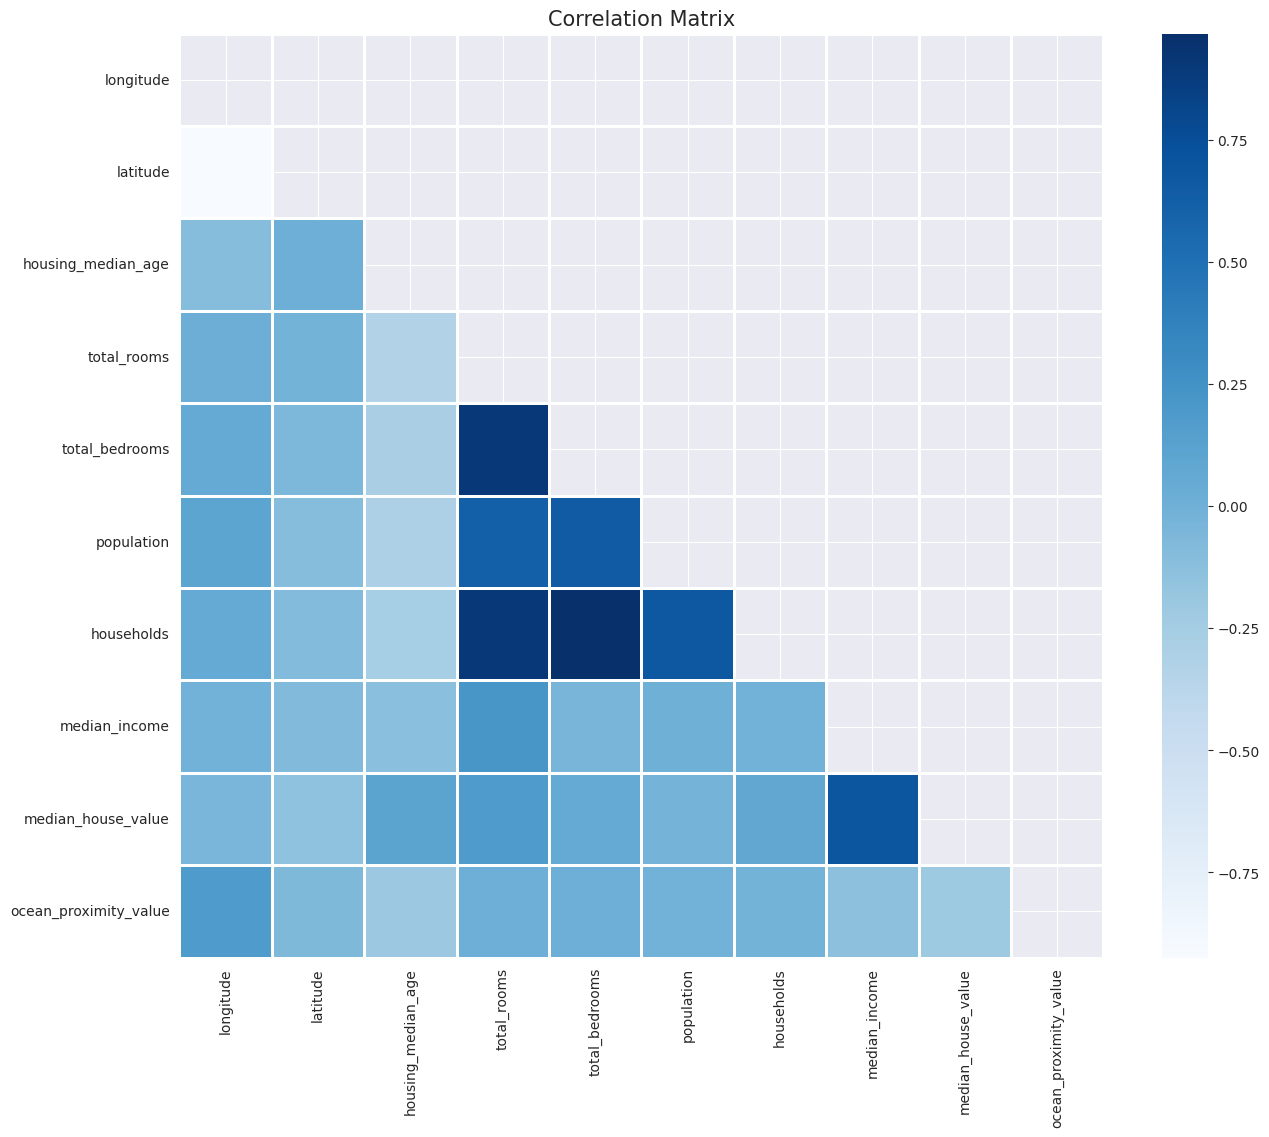

In [14]:
plot_corr_matrix(df_data)

In [15]:
df_data["household_rooms"]=df_data['households']/df_data["total_rooms"]
df_data["rooms_bedrooms"]= df_data["total_rooms"]/df_data["total_bedrooms"]
df_data=df_data.drop(columns=["households","total_rooms","total_bedrooms"])

                       longitude  latitude  housing_median_age  population  \
longitude               1.000000 -0.924664           -0.108197    0.099773   
latitude               -0.924664  1.000000            0.011173   -0.108785   
housing_median_age     -0.108197  0.011173            1.000000   -0.296244   
population              0.099773 -0.108785           -0.296244    1.000000   
median_income          -0.015176 -0.079809           -0.119034    0.004834   
median_house_value     -0.045967 -0.144160            0.105623   -0.024650   
ocean_proximity_value   0.180381 -0.067586           -0.204882   -0.008511   
household_rooms         0.090355 -0.148364            0.173777    0.032884   
rooms_bedrooms         -0.081308  0.082473           -0.117698   -0.079997   

                       median_income  median_house_value  \
longitude                  -0.015176           -0.045967   
latitude                   -0.079809           -0.144160   
housing_median_age         -0.119034   

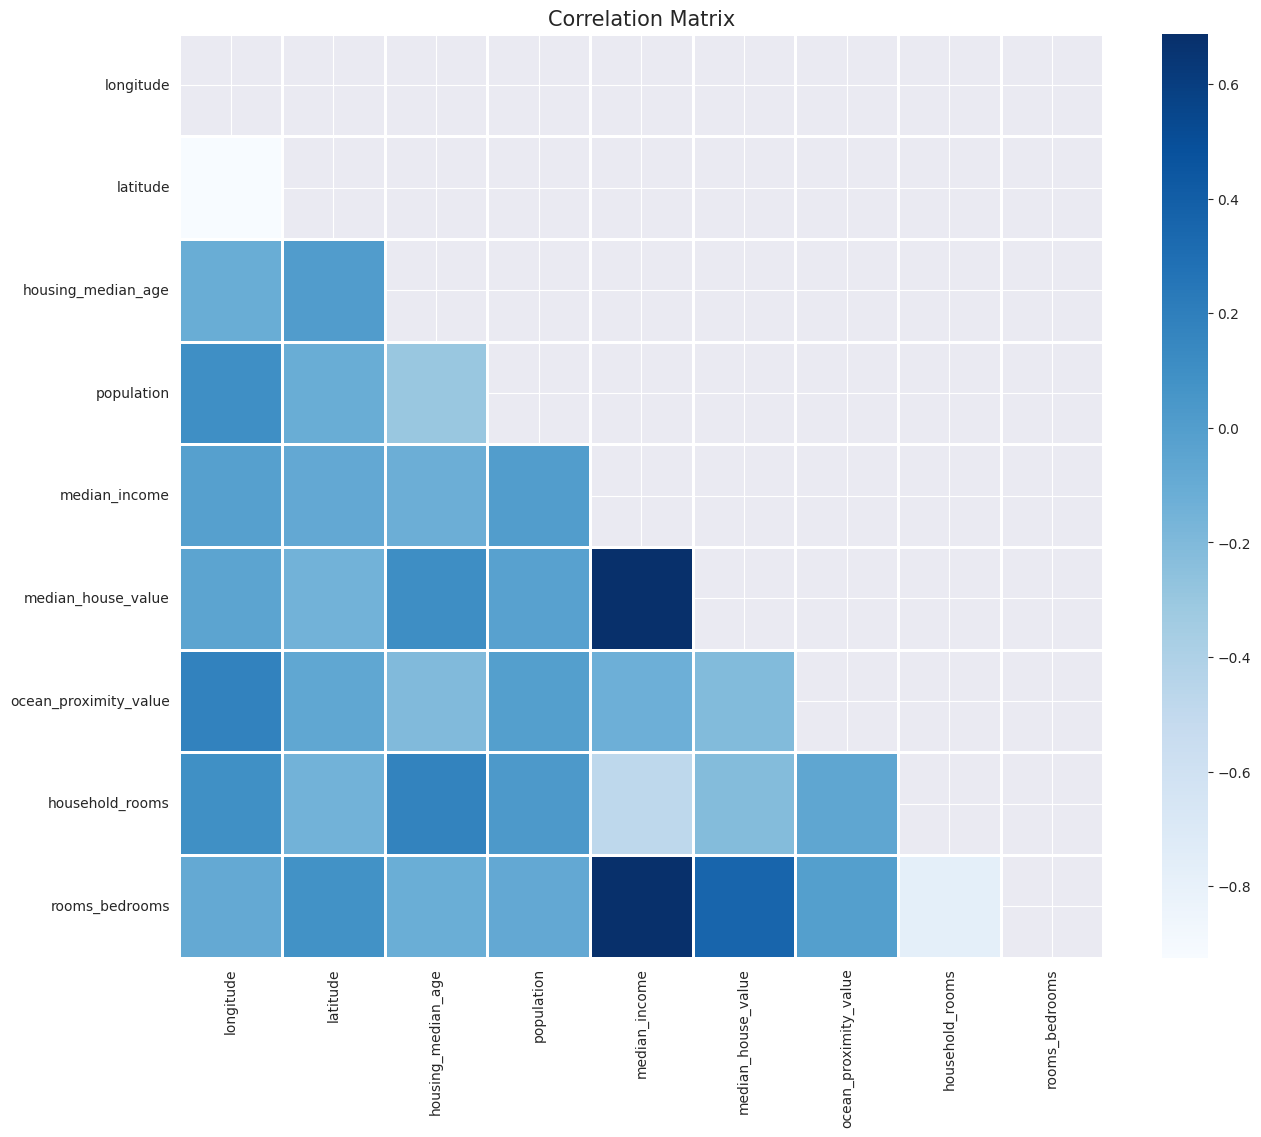

In [16]:
plot_corr_matrix(df_data)

In [17]:
X=df_data.drop(columns="median_house_value")
y=df_data["median_house_value"]

In [18]:
class Linear_Regression_Scratch():
    def __init__(self):
        self.coeff=None

    def calculate_cost(self, X,y, theta):
        m= len(X)
        h_x=np.dot(X,theta)
        residual= (h_x-y)**2
        mse=residual.mean()
        cost=mse/2
        return cost

    def gradient_descent(self, X,y,theta,lr,iterations):
        m= len(X)
        cost_result=[]
        for i in range(iterations):
            h_x = np.dot(X,theta)
            diff=h_x - y
            grad_theta= np.dot(X.T, diff)/m
            theta = theta - (lr*grad_theta)
            cost=self.calculate_cost(X,y,theta)
            cost_result.append(cost)

        self.plot_loss(cost_result)
        return theta     
   
    def gradient_descent_momentum(self, X,y,theta,lr,iterations,beta):
        m= len(X)
        cost_result=[]
        momentum=theta
        for i in range(iterations):
            h_x = np.dot(X,theta)
            diff=h_x - y
            grad_theta= np.dot(X.T, diff)/m
            momentum = beta*momentum + (1-beta)*grad_theta
            theta = theta - (lr*momentum)
            cost=self.calculate_cost(X,y,theta)
            cost_result.append(cost)

        self.plot_loss(cost_result)
        return theta     
    
    def predict(self, X):
        y_pred=np.dot(X,self.coeff)
        return y_pred

    def plot_loss(self,cost_result):
        plt.plot(cost_result)
        plt.ylabel("Cost Function")
        plt.xlabel("Iterations")
        plt.title("Plot of Cost Function with respect to iterations")
    
    def fit(self,X,y,lr,iterations, is_momentum=False):
        theta=np.zeros([X.shape[1],1])
        if(is_momentum == False):
            self.coeff=self.gradient_descent(X,y,theta, lr,iterations) 
        else:    
            self.coeff=self.gradient_descent_momentum(X,y,theta, lr,iterations, 0.8) 

In [19]:
def data_scaling(X_scaled,y):
    X_array=np.array(X_scaled)
    Y_array=np.array(y)
    print(f"Dimensions of X array: f{X_array.shape}")
    print(f"Dimensions of Y array {Y_array.shape}")
    Y_array=Y_array.reshape(-1,1)
    print(f"Dimensiona of Y array after flatten : f{Y_array.shape}")
    return X_array,Y_array
    
def add_intercept(X_array):    
    m=len(X_array)
    print(f"Dimensions of X array before addition of intercept: f{X_array.shape}")
    X_array= np.append(np.ones([m,1]),X_array, axis=1)
    print(f"Dimensions of X array after addition of intercept {X_array.shape}")
    return X_array

In [20]:
X=df_data.drop(columns="median_house_value")
y=df_data["median_house_value"]
X_train, X_test, Y_train,Y_test= train_test_split(X,y, test_size=0.30, random_state=42)

In [21]:
scaler= StandardScaler()
X_scaled=scaler.fit_transform(X_train)

X_array,Y_array= data_scaling(X_scaled,Y_train)
X_array = add_intercept(X_array)


Dimensions of X array: f(14448, 8)
Dimensions of Y array (14448,)
Dimensiona of Y array after flatten : f(14448, 1)
Dimensions of X array before addition of intercept: f(14448, 8)
Dimensions of X array after addition of intercept (14448, 9)



Based on SGD with momentum



array([[206923.96089424],
       [-83753.97491403],
       [-87258.76825177],
       [ 11674.41539445],
       [ -2630.95288621],
       [ 83234.91204554],
       [ -3034.93099242],
       [ -8785.93877245],
       [-21618.18786693]])

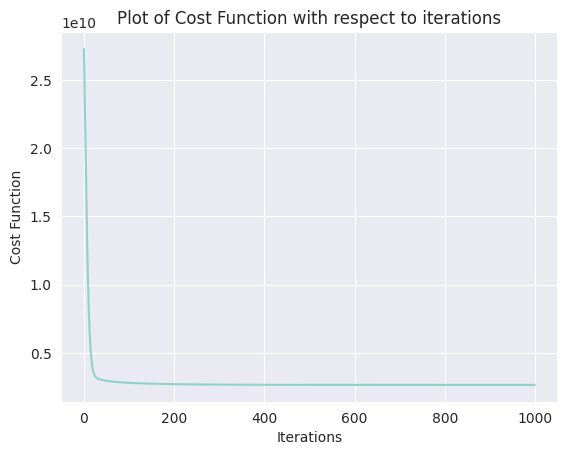

In [22]:
print("\nBased on SGD with momentum\n")
lr_scratch=Linear_Regression_Scratch()
lr_scratch.fit(X_array, Y_array,0.08,1000,True)
lr_scratch.coeff


Based on SGD without momentum



array([[206923.96089424],
       [-83699.94402056],
       [-87204.11648895],
       [ 11679.65074638],
       [ -2629.22073226],
       [ 83244.88826118],
       [ -3038.77890311],
       [ -8780.33527231],
       [-21620.32522367]])

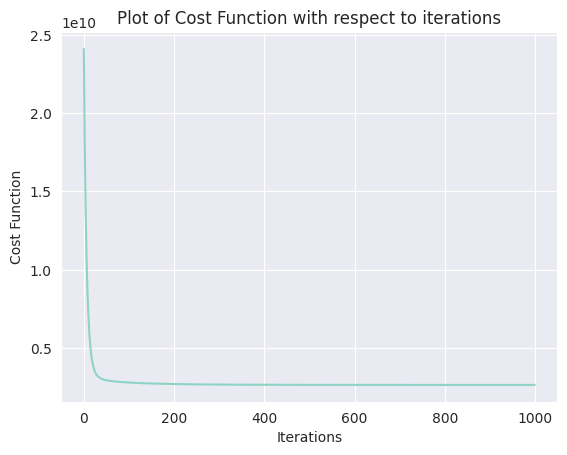

In [23]:
print("\nBased on SGD without momentum\n")
lr_scratch=Linear_Regression_Scratch()
lr_scratch.fit(X_array, Y_array,0.08,1000,False)
lr_scratch.coeff